In [5]:
import pandas as pd
from darts import TimeSeries
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    """
    Function to fix and standardize datetime in the given DataFrame.
    
    Parameters:
    - X: DataFrame to be modified.
    - name: String representing the name of the DataFrame, used for logging.
    
    Returns:
    - Modified DataFrame with standardized datetime.
    """

    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')

    # Sort DataFrame by the new datetime column ('ds') and set it as the index
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Log the shape of the DataFrame before dropping rows with in-between minutes
    print(f"Shape of {name} before dropping in-between hour rows: ", X.shape)

    # Identify and log gaps in the date sequence
    print(f"HEIHEI: {name} gaps in dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())
    print(f"HEIHEI: {name} first gap in dates: ", X[X.index.to_series().diff().dt.total_seconds().gt(60*15)==True].index[:1])

    # Calculate and log the size of each gap in the date sequence
    temp = X.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print(f"HEIHEI: {name} list of size (in days) of each gap: ", temp[temp.gt(60*15)].values / (60*60*24))
    
    # temporarily transform into darts time series to fill missing dates
    # get date_calc if date_calc is column in X
    temp_calc = None
    if "date_calc" in X.columns:
        temp_calc = X["date_calc"]
        X.drop(columns=['date_calc'], inplace=True)
    X = TimeSeries.from_dataframe(df=X, freq="15T", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    if temp_calc is not None:
        X["date_calc"] = temp_calc

    print(f"HEIHEI: {name} gaps in dates after filling missing dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())


    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]

    # Log the shape of the DataFrame after dropping rows with in-between minutes
    print(f"Shape of {name} after dropping in-between hour rows: ", X.shape)

    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




# location_map = {
#     "A": 0,
#     "B": 1,
#     "C": 2
# }


def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)


    # # cast all columns to float64
    # X_train = X_train.astype('float64')
    # X_test = X_test.astype('float64')


    print(f"X_train_observed shape: {X_train_observed.shape}")
    print(f"X_train_estimated shape: {X_train_estimated.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")



    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    print("y_train columns: ", y_train.columns)

    # temporarily transform into darts time series to fill missing dates
    print("Shape of y_train before filling missing dates: ", y_train.shape)
    y_train = TimeSeries.from_dataframe(df=y_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("Shape of y_train after filling missing dates: ", y_train.shape)


    # number of gaps in X_train_observed + X_train_estimated before
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated before: ", X_train_observed.index.to_series().diff().dt.total_seconds().gt(3600).sum() + X_train_estimated.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    X_train = pd.concat([X_train_observed, X_train_estimated])
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated after: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    # print size of gaps in X_train
    temp = X_train.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print("LOOK: list of size (in days) of each gap: ", temp[temp.gt(3600)].values / (60*60*24))
    print("if the number is bigger after than before that means there is a gap in time between the observed and estimated training sets")

    # print info on dates in X_train, and if there are any missing dates
    print("X_train dates info: ", X_train.index.min(), X_train.index.max(), X_train.index.max() - X_train.index.min())
    print("X_test dates info: ", X_test.index.min(), X_test.index.max(), X_test.index.max() - X_test.index.min())
    print("y_train dates info: ", y_train.index.min(), y_train.index.max(), y_train.index.max() - y_train.index.min())

    # any gaps in dates?
    print("X_train gaps in dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("y_train gaps in dates: ", y_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    # temporarily transform into darts time series to fill missing dates
    X_train = TimeSeries.from_dataframe(df=X_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    X_test = TimeSeries.from_dataframe(df=X_test, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("X_train gaps in dates after filling missing dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates after filling missing dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    # print Number of missing values in X train
    print("Number of missing values in X_train: ", X_train.isnull().sum().sum())
    print("Number of missing values in X_test: ", X_test.isnull().sum().sum())
    # y_train missing values
    print("Number of missing values in y_train: ", y_train.isnull().sum().sum())
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)
    print("Number of missing values in X_train after merging with y_train: ", X_train.drop(columns=['y']).isnull().sum().sum())



    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
    


# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
y_trains = []
# Loop through locations
for loc in locations:
    print("\n\n")
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Concatenate observed and estimated datasets for each location
    #X_train = pd.concat([X_train_estimated, X_train_observed])
    



    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    print(f"Final shape of X_train for location {loc}: ", X_train.shape)
    print(f"Final shape of X_test for location {loc}: ", X_test.shape)

    # print(y_train.head(), y_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(type(X_train['y']))

    # Save data to csv
    X_train.to_csv(f'{loc}/X_train.csv', index=True)
    X_test.to_csv(f'{loc}/X_test.csv', index=True)


    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)

print(f"Final shape of X_train: ", X_train.shape)
print(f"Final shape of X_test: ", X_test.shape)

X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)




Processing location A...
Shape of X_train_observed before dropping in-between hour rows:  (118669, 45)
HEIHEI: X_train_observed gaps in dates:  0
HEIHEI: X_train_observed first gap in dates:  DatetimeIndex([], dtype='datetime64[ns]', name='ds', freq=None)
HEIHEI: X_train_observed list of size (in days) of each gap:  []
HEIHEI: X_train_observed gaps in dates after filling missing dates:  0
Shape of X_train_observed after dropping in-between hour rows:  (29668, 45)
Shape of X_train_estimated before dropping in-between hour rows:  (17576, 46)
HEIHEI: X_train_estimated gaps in dates:  1
HEIHEI: X_train_estimated first gap in dates:  DatetimeIndex(['2023-01-27'], dtype='datetime64[ns]', name='ds', freq=None)
HEIHEI: X_train_estimated list of size (in days) of each gap:  [1.01041667]
HEIHEI: X_train_estimated gaps in dates after filling missing dates:  0
Shape of X_train_estimated after dropping in-between hour rows:  (4418, 46)
Shape of X_test before dropping in-between hour rows:  (2880

In [6]:
import pandas as pd
# add sin and cos of sun_elevation:d and sun_azimuth:d

# change the name of df to X_train, and test_df to X_test
X_train['sin_sun_elevation'] = np.sin(np.deg2rad(X_train['sun_elevation:d']))

X_test['sin_sun_elevation'] = np.sin(np.deg2rad(X_test['sun_elevation:d']))

# add global_rad_1h:J = diffuse_rad_1h:J + direct_rad_1h:J
X_train['global_rad_1h:J'] = X_train['diffuse_rad_1h:J'] + X_train['direct_rad_1h:J']
X_test['global_rad_1h:J'] = X_test['diffuse_rad_1h:J'] + X_test['direct_rad_1h:J']

# dew_or_rime:idx, Change this to one variable for is_dew and one variable for is_rime (dew:1, rime:-1)
X_train['is_dew'] = X_train['dew_or_rime:idx'].apply(lambda x: 1 if x == 1 else 0)
X_train['is_rime'] = X_train['dew_or_rime:idx'].apply(lambda x: 1 if x == -1 else 0)

X_test['is_dew'] = X_test['dew_or_rime:idx'].apply(lambda x: 1 if x == 1 else 0)
X_test['is_rime'] = X_test['dew_or_rime:idx'].apply(lambda x: 1 if x == -1 else 0)


# EXOGENOUS = [
#     'estimated_diff_hours',
#     "absolute_humidity_2m:gm3",
#     "air_density_2m:kgm3",
#     "dew_point_2m:K",
#     "diffuse_rad_1h:J",
#     "direct_rad_1h:J",
#     "effective_cloud_cover:p",
#     "fresh_snow_1h:cm",
#     "snow_depth:cm",
#     "sun_elevation:d",
#     "sun_azimuth:d",
#     "t_1000hPa:K",
#     "visibility:m",
#     "wind_speed_10m:ms",
#     "is_dew",
#     "is_rime",
#     "sin_sun_elevation",
#     "global_rad_1h:J",
#     ]
#additional_features_for_testing = 

# df = df[EXOGENOUS + ["y", "location"]]
# test_df = test_df[EXOGENOUS+ ["location"]]

# # save to X_train_feature_engineered.csv
# df.to_csv('X_train_feature_engineered.csv', index=True)
# test_df.to_csv('X_test_feature_engineered.csv', index=True)



# EDA

**`train_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,9990,154,,,6.012573,2.717458,0.5,4.0,5.4,7.9,16.1,float64,10,0.001,float,numeric,
air_density_2m:kgm3,9990,259,,,1.255297,0.036282,1.144,1.23,1.255,1.278,1.441,float64,10,0.001,float,numeric,
ceiling_height_agl:m,7812,7152,,,2827.654979,2554.549717,27.799999,1047.200043,1786.700012,3904.549988,12169.599609,float64,2188,0.2188,float,numeric,
clear_sky_energy_1h:J,9990,5247,,,514412.656591,816477.97434,0.0,0.0,4615.800049,788811.265625,3005179.5,float64,10,0.001,float,numeric,
clear_sky_rad:W,9990,3255,,,142.649289,227.101078,0.0,0.0,0.0,223.450005,835.0,float64,10,0.001,float,numeric,
cloud_base_agl:m,9082,7862,,,1699.49521,1810.794836,27.799999,568.024994,1137.700012,2009.524994,11688.700195,float64,918,0.0918,float,numeric,
dew_or_rime:idx,9990,3,,,0.003403,0.238434,-1.0,0.0,0.0,0.0,1.0,float64,10,0.001,float,category,
dew_point_2m:K,9990,382,,,275.225075,6.831663,247.300003,270.600006,274.899994,280.600006,292.299988,float64,10,0.001,float,numeric,
diffuse_rad:W,9990,1890,,,39.726897,60.921499,0.0,0.0,0.0,65.875002,316.5,float64,10,0.001,float,numeric,
diffuse_rad_1h:J,9990,5246,,,143388.457405,218073.513779,0.0,0.0,10124.950195,235629.628906,1130209.875,float64,10,0.001,float,numeric,


**`test_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,2160,106,,,8.206481,2.201396,3.2,6.6,8.0,10.0,14.2,float64,2448,0.53125,float,numeric,
air_density_2m:kgm3,2160,153,,,1.232807,0.032116,1.142,1.209,1.238,1.26,1.301,float64,2448,0.53125,float,numeric,
ceiling_height_agl:m,1473,1391,,,2938.389816,2913.640973,30.6,891.799988,1553.900024,4021.300049,11468.0,float64,3135,0.680339,float,numeric,
clear_sky_energy_1h:J,2160,1807,,,1227746.694759,1104468.654105,0.0,64338.124023,1056303.125,2372037.5,3005707.0,float64,2448,0.53125,float,numeric,
clear_sky_rad:W,2160,1044,,,341.056621,307.7291,0.0,13.65,273.849991,646.874985,835.099976,float64,2448,0.53125,float,numeric,
cloud_base_agl:m,1879,1771,,,1797.160245,2046.394442,29.799999,486.899994,997.799988,2298.300049,11467.799805,float64,2729,0.592231,float,numeric,
dew_or_rime:idx,2160,3,,,0.040741,0.202365,-1.0,0.0,0.0,0.0,1.0,float64,2448,0.53125,float,category,
dew_point_2m:K,2160,202,,,280.783241,4.378817,268.0,277.899994,281.0,284.299988,290.200012,float64,2448,0.53125,float,numeric,
diffuse_rad:W,2160,985,,,84.915695,78.422513,0.0,6.925,73.700001,135.600006,312.600006,float64,2448,0.53125,float,numeric,
diffuse_rad_1h:J,2160,1806,,,305696.513643,278146.236668,0.0,36756.901367,272526.046875,488256.03125,1086246.25,float64,2448,0.53125,float,numeric,


**Types warnings summary**

,train_data,test_data,warnings
y,float,--,warning


### Feature Distance

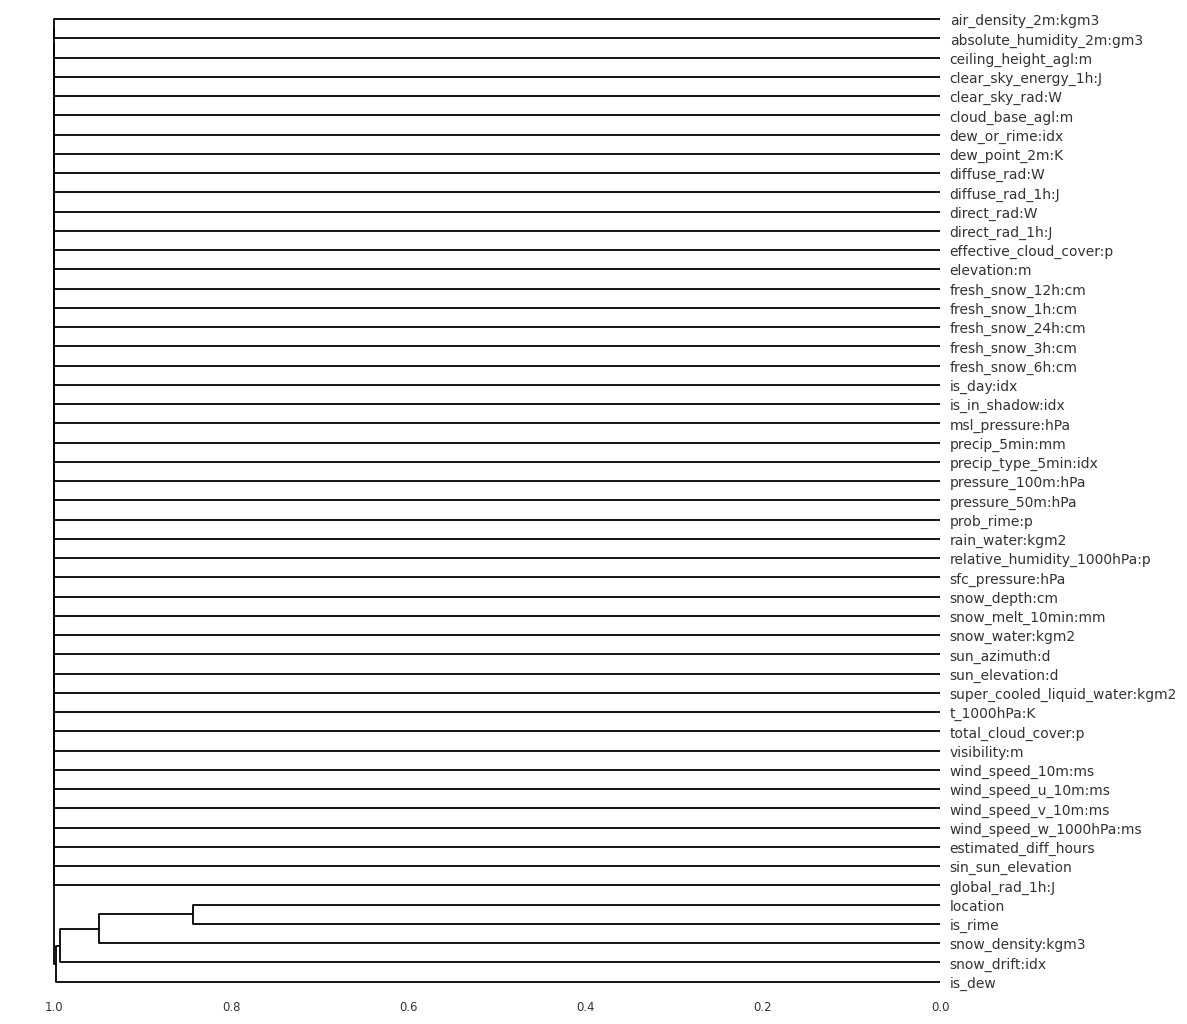

In [7]:
import autogluon.eda.auto as auto

auto.dataset_overview(train_data=X_train, test_data=X_test, label="y")

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,10000,295.26029,787.46272,-0.0,0.0,0.0,176.4,5365.36,float64,2539,,,float,


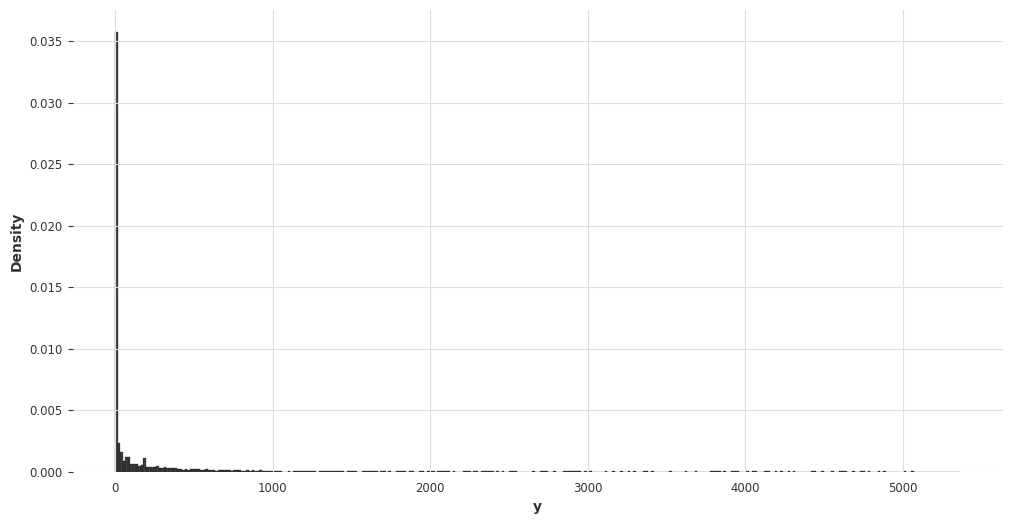

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `y` >= `0.5` (sample size: 10000)**

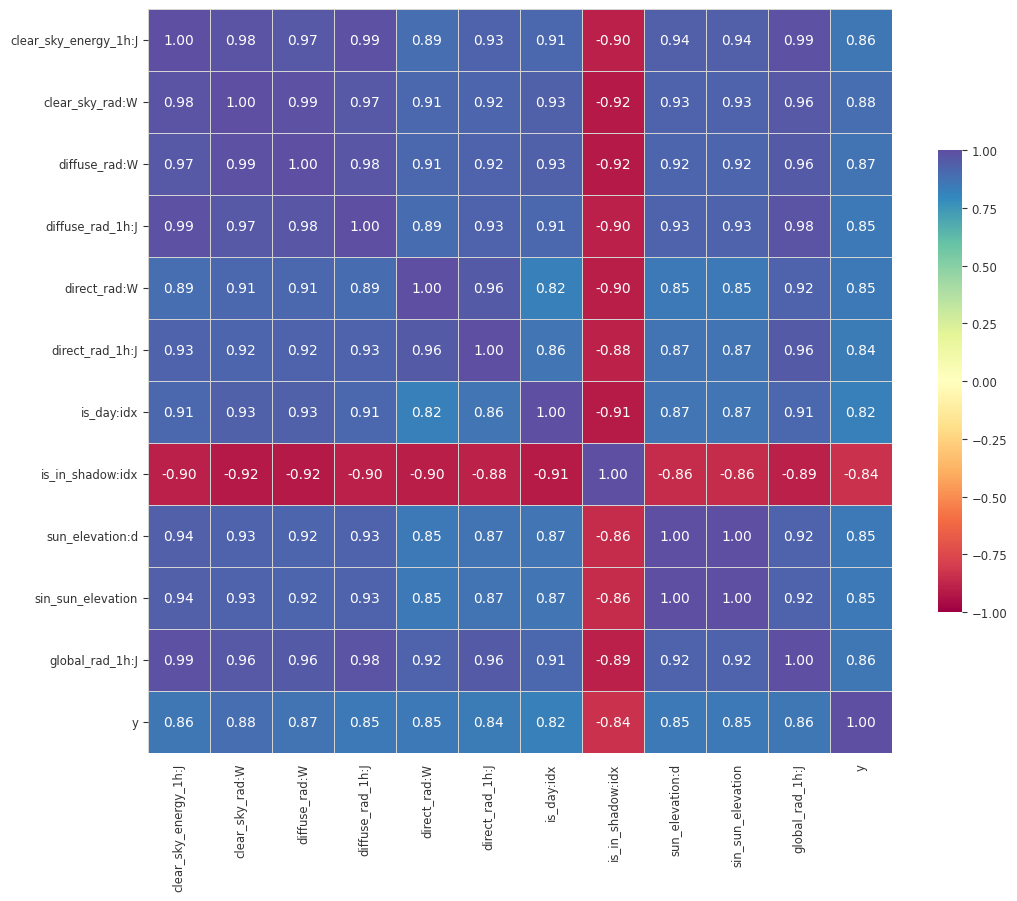

**Feature interaction between `clear_sky_rad:W`/`y` in `train_data` (sample size: 10000)**

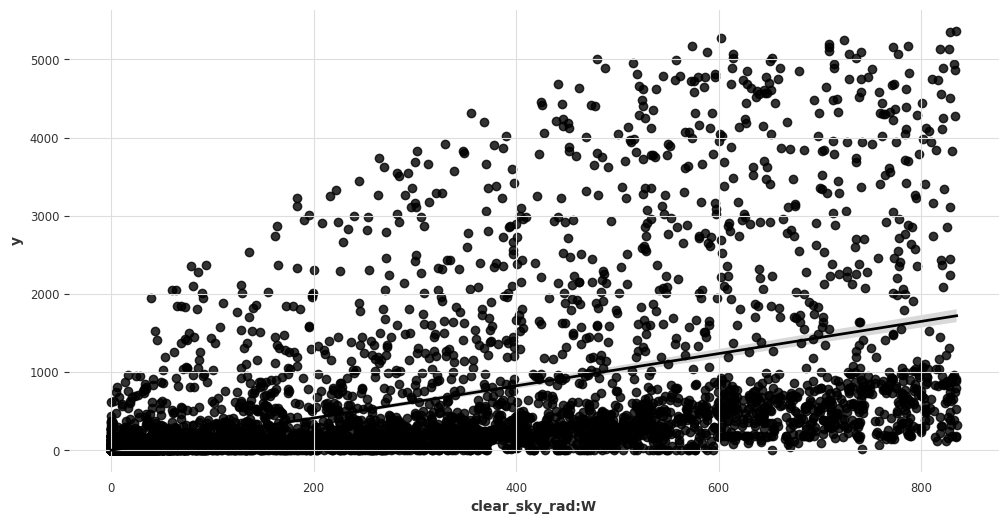

**Feature interaction between `diffuse_rad:W`/`y` in `train_data` (sample size: 10000)**

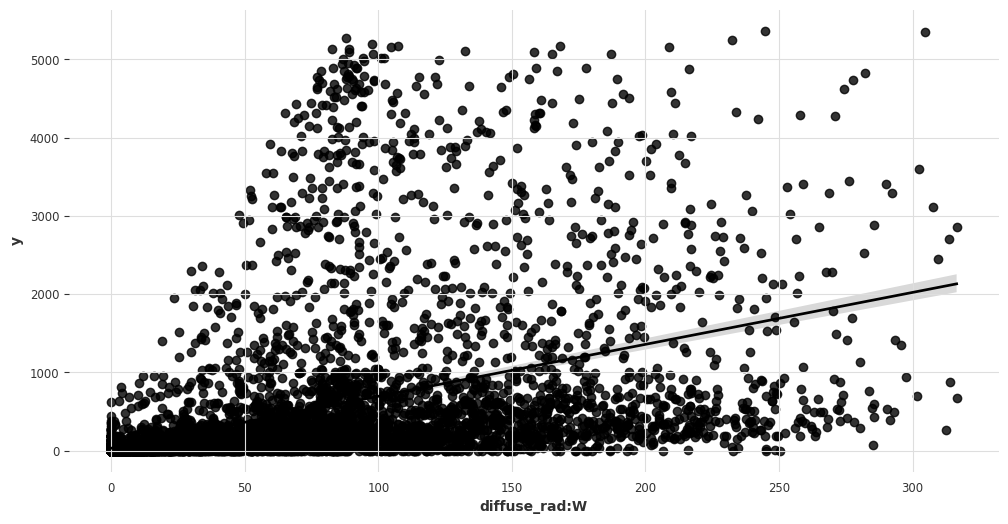

**Feature interaction between `clear_sky_energy_1h:J`/`y` in `train_data` (sample size: 10000)**

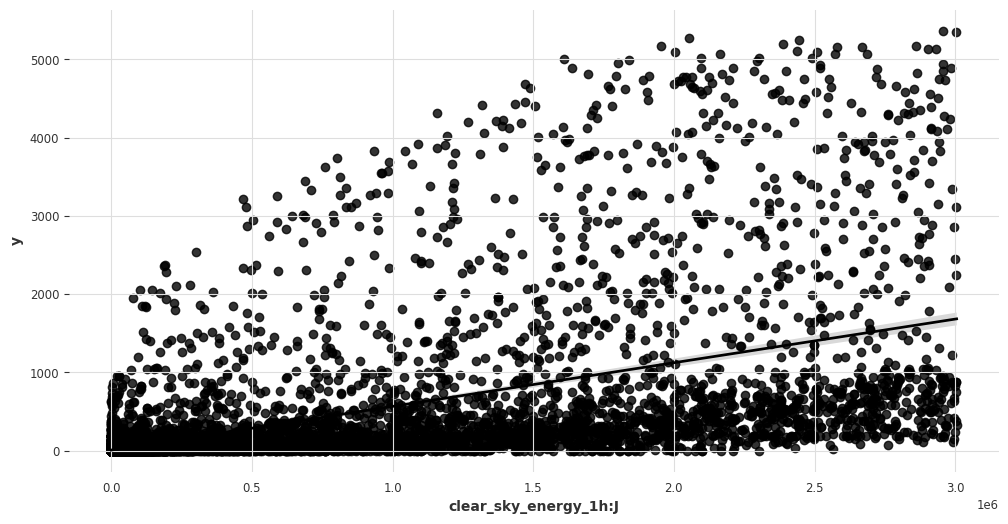

**Feature interaction between `global_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

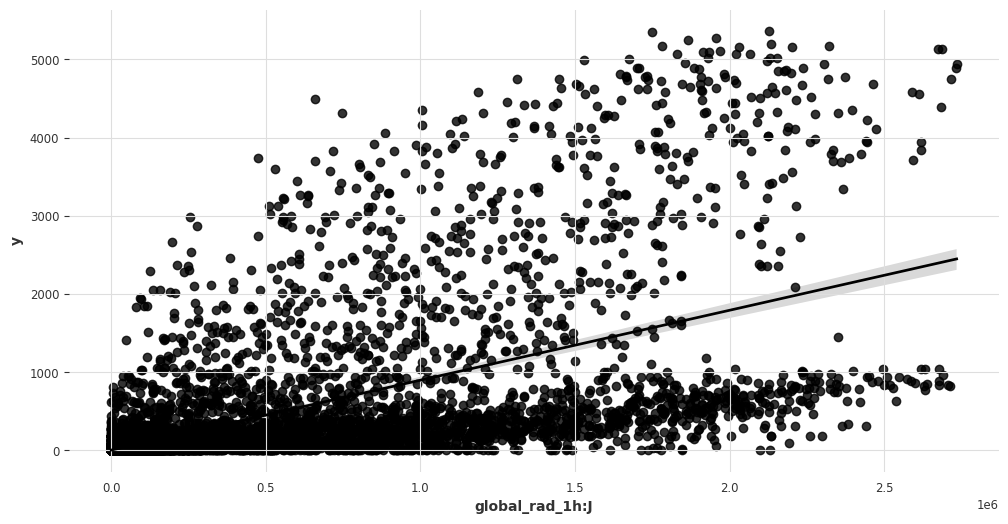

**Feature interaction between `direct_rad:W`/`y` in `train_data` (sample size: 10000)**

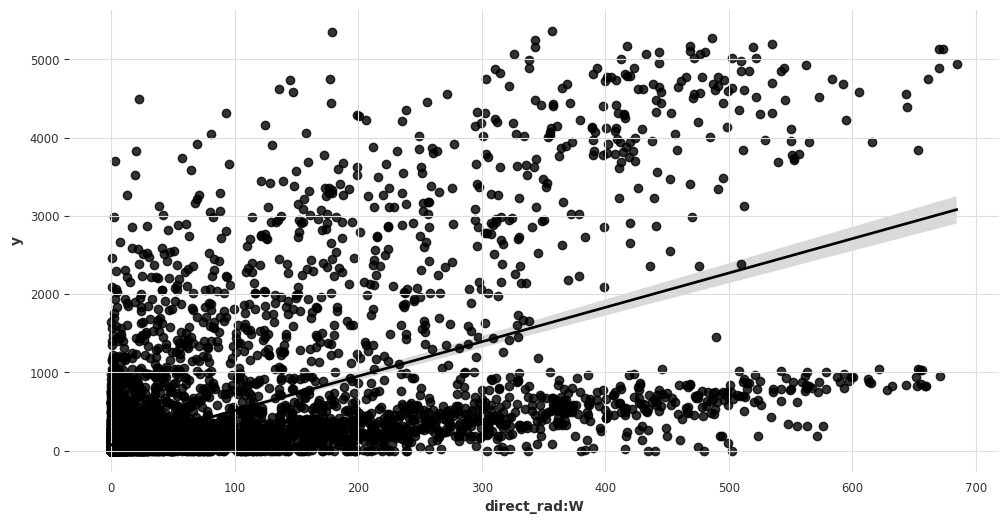

**Feature interaction between `diffuse_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

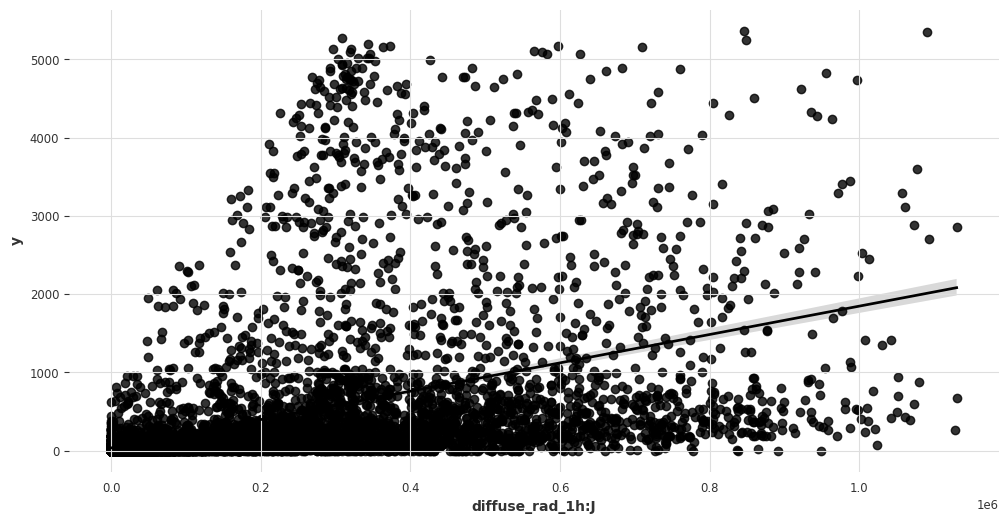

**Feature interaction between `sun_elevation:d`/`y` in `train_data` (sample size: 10000)**

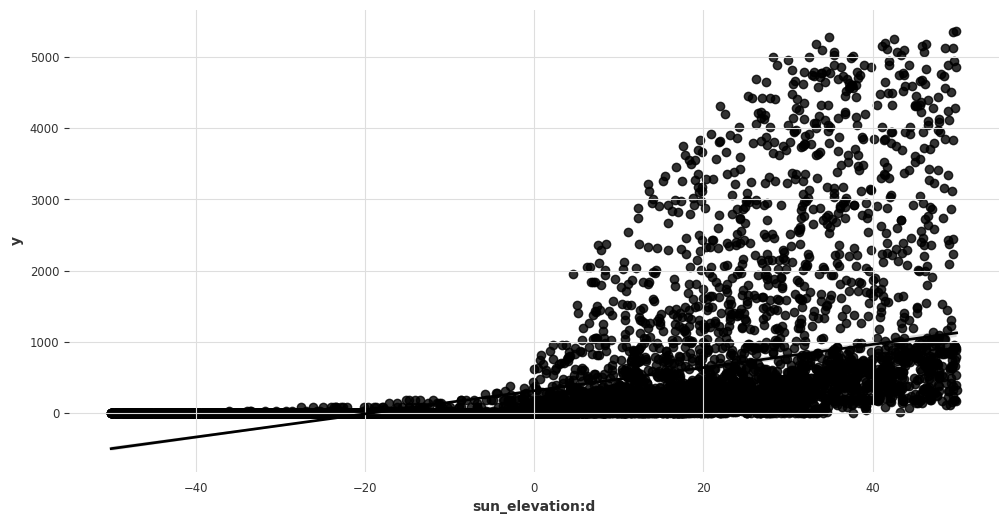

**Feature interaction between `sin_sun_elevation`/`y` in `train_data` (sample size: 10000)**

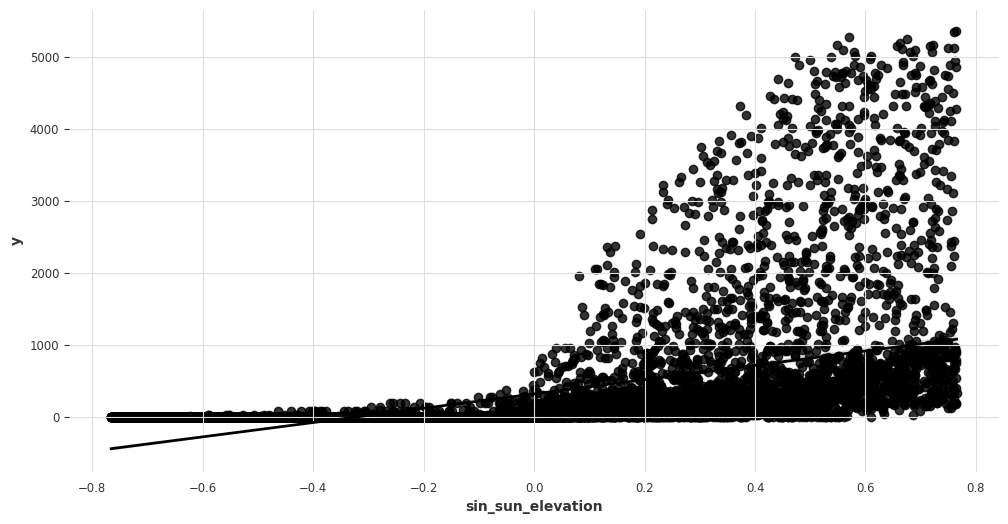

**Feature interaction between `direct_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

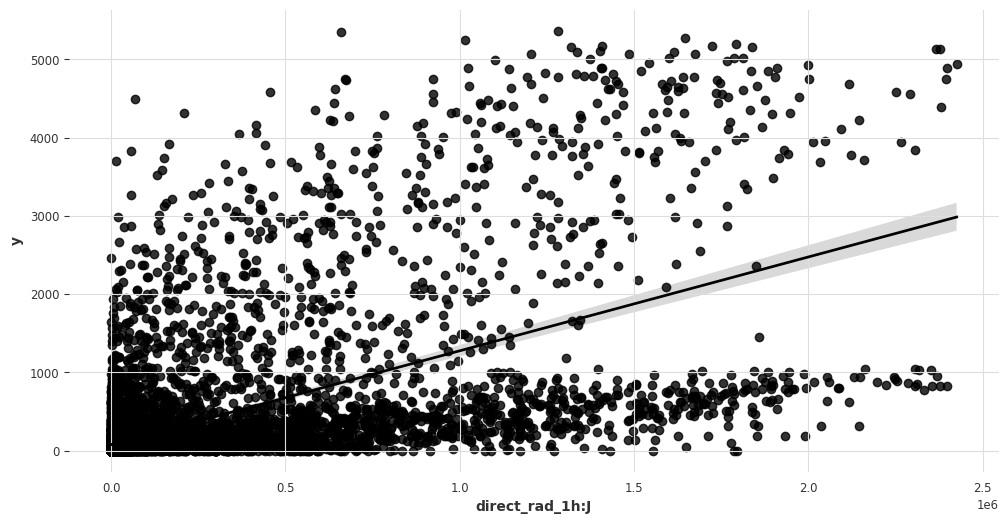

**Feature interaction between `is_day:idx`/`y` in `train_data` (sample size: 10000)**

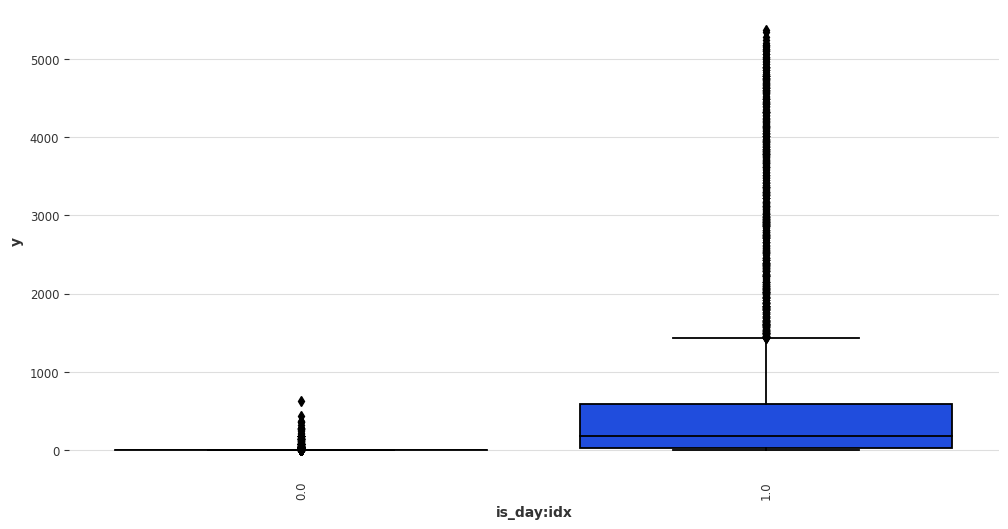

**Feature interaction between `is_in_shadow:idx`/`y` in `train_data` (sample size: 10000)**

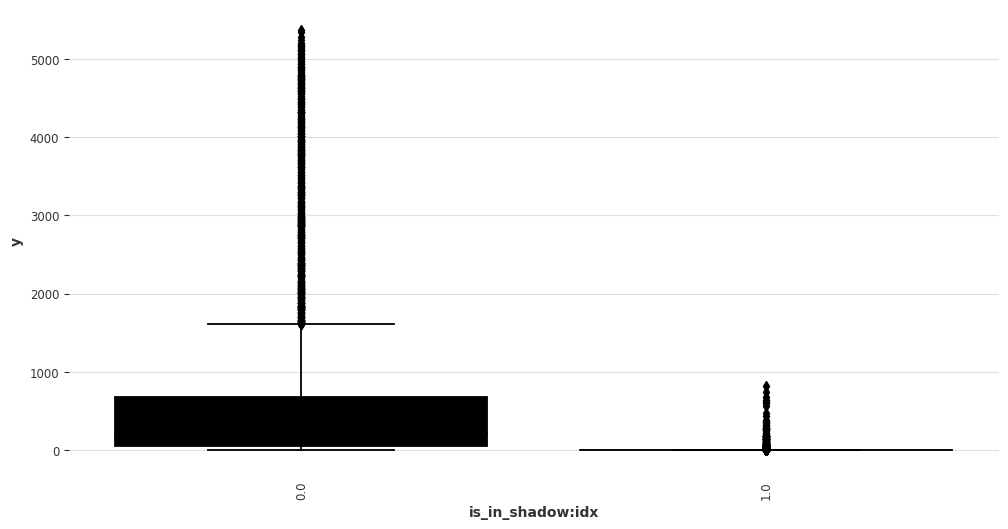

In [9]:
auto.target_analysis(train_data=X_train, label="y")

No path specified. Models will be saved in: "AutogluonModels/ag-20231005_173502/"


### Model Prediction for y

Using validation data for `Test` points

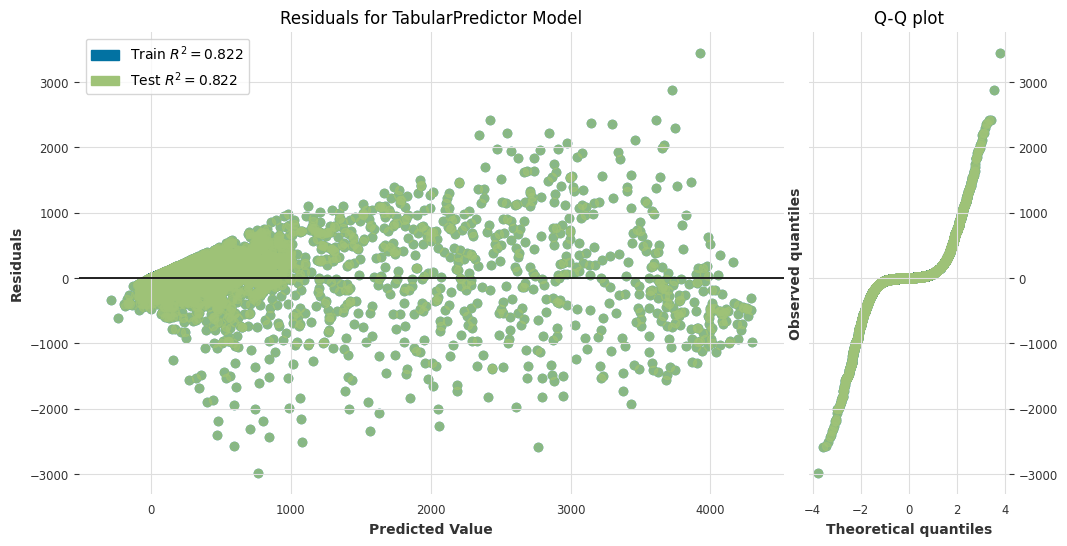

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-311.066158,-277.326025,0.028044,0.002326,1.231081,0.028044,0.002326,1.231081,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
location,293.519303,12.613568,4.082420e-07,5,319.490813,267.547793
direct_rad:W,75.079013,3.067718,3.337355e-07,5,81.395487,68.762540
clear_sky_rad:W,70.461467,5.584252,4.694684e-06,5,81.959520,58.963414
elevation:m,49.259586,5.950099,2.505609e-05,5,61.510923,37.008249
global_rad_1h:J,26.291609,3.265325,2.797300e-05,5,33.014959,19.568259
sun_azimuth:d,24.656489,1.780751,3.242313e-06,5,28.323080,20.989897
direct_rad_1h:J,18.739185,2.305438,2.694498e-05,5,23.486113,13.992257
effective_cloud_cover:p,10.553958,2.069490,1.686669e-04,5,14.815066,6.292850
sun_elevation:d,8.153683,1.904721,3.327628e-04,5,12.075530,4.231836
diffuse_rad:W,4.112478,1.135016,6.308197e-04,5,6.449491,1.775464


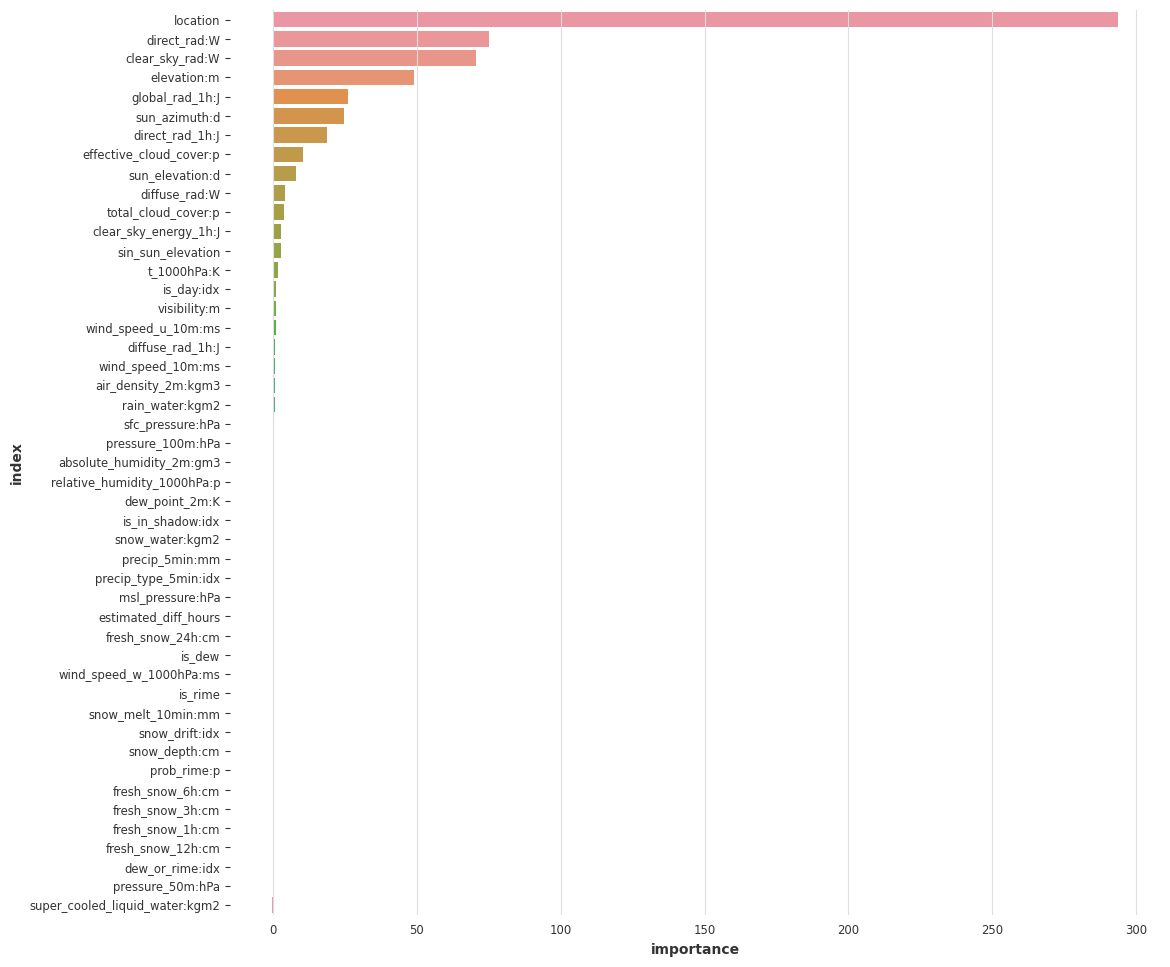

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,wind_speed_w_1000hPa:ms,estimated_diff_hours,location,sin_sun_elevation,global_rad_1h:J,is_dew,is_rime,y,y_pred,error
ds,,,,,,,,,,,,,,,,,,,,,
2020-04-23 11:00:00,5.4,1.255,2400173.750,678.299988,0.0,275.200012,120.199997,4.119372e+05,499.600006,1.778905e+06,...,0.0,0.0,C,0.631326,2.190842e+06,0,0,98.00,784.811951,3448.901963
2020-04-23 11:00:00,5.4,1.259,2397806.500,677.599976,0.0,275.200012,127.900002,4.391003e+05,485.299988,1.725954e+06,...,0.0,0.0,A,0.630811,2.165055e+06,0,0,475.86,3924.761963,3448.901963
2020-04-23 11:00:00,5.4,1.259,2397806.500,677.599976,0.0,275.200012,127.900002,4.391003e+05,485.299988,1.725954e+06,...,0.0,0.0,A,0.630811,2.165055e+06,0,0,475.86,784.811951,3448.901963
2020-04-23 11:00:00,5.4,1.255,2400173.750,678.299988,0.0,275.200012,120.199997,4.119372e+05,499.600006,1.778905e+06,...,0.0,0.0,C,0.631326,2.190842e+06,0,0,98.00,3924.761963,3448.901963
2021-10-05 09:00:00,8.4,1.215,803033.875,265.100006,0.0,281.600006,105.400002,3.176766e+05,67.500000,1.755801e+05,...,-0.0,0.0,C,0.303567,4.932567e+05,0,0,176.40,115.741486,2977.574358
2021-10-05 09:00:00,8.5,1.218,801049.125,264.399994,0.0,281.799988,107.599998,3.244821e+05,57.400002,1.502394e+05,...,-0.0,0.0,A,0.303052,4.747215e+05,0,0,3742.42,764.845642,2977.574358
2021-10-05 09:00:00,8.5,1.218,801049.125,264.399994,0.0,281.799988,107.599998,3.244821e+05,57.400002,1.502394e+05,...,-0.0,0.0,A,0.303052,4.747215e+05,0,0,3742.42,115.741486,2977.574358
2021-10-05 09:00:00,8.4,1.215,803033.875,265.100006,0.0,281.600006,105.400002,3.176766e+05,67.500000,1.755801e+05,...,-0.0,0.0,C,0.303567,4.932567e+05,0,0,176.40,764.845642,2977.574358
2020-05-08 11:00:00,6.3,1.244,2661117.000,749.900024,0.0,277.200012,165.100006,5.885981e+05,361.600006,1.232320e+06,...,0.0,0.0,A,0.690441,1.820919e+06,0,0,840.18,3722.738281,2882.558281


In [10]:
auto.quick_fit(X_train, "y", show_feature_importance_barplots=True, val_size=0.9)

In [22]:
# drop the columns with tons of missing values
to_drop = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "wind_speed_v_10m:ms"
]
X_train.drop(columns=to_drop, inplace=True, errors='ignore')
X_test.drop(columns=to_drop, inplace=True, errors='ignore')

In [23]:
auto.detect_anomalies(
    train_data=X_train.dropna().reset_index(drop=True),
    test_data=X_test.dropna().reset_index(drop=True),
    label="y",
    threshold_stds=3,
    show_top_n_anomalies=5,
    explain_top_n_anomalies=1,
    fig_args={"figsize": (6, 4)},
    chart_args={
        "normal. color": "lightgrey",
        "anomaly. color": "orange",
    },
)

ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

# Starting

In [11]:
import os
# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

Last submission number: 70
Now creating submission number: 71


In [12]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('X_train_raw.csv')
train_data.drop(columns=['ds'], inplace=True)

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60
presets = 'best_quality'

In [13]:
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}").fit(train_data, presets=presets, time_limit=time_limit)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_71/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   2.18 GB / 494.38 GB (0.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    93024
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, -0.0, 287.01965, 766.40778)
	If 'regression' is not the correct problem_type, please manually specify the problem_type

In [ ]:
predictors = [predictor, predictor, predictor]

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

In [ ]:
predictor.fit_summary(show_plot=True)

In [ ]:
predictor.feature_importance(train_data)

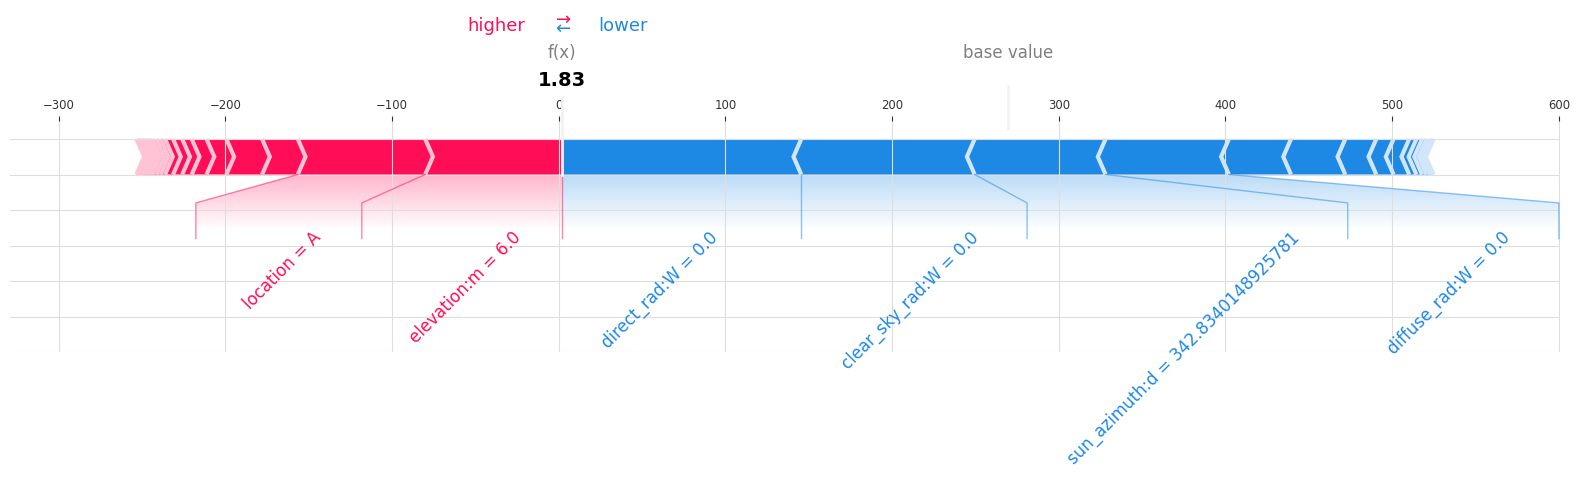

In [17]:
auto.explain_rows(train_data=X_train, model=predictor, plot="force", rows=X_train[:2])